El código lee y transforma datos de ingreso a nivel individual y calcula pobreza a nivel de hogar. 


### Variables de entrada

1. **De `datos_p_pobreza(Q)`:**
    - `'ID'`, `'RADIO_REF_ID'`, `'DPTO'`, `'PROV'`, `'AGLOMERADO'`, `'HOGAR_REF_ID'` (IDs de referencia)
    - `'P47T'` (INGRESO TOTAL $$$)
    - `'P10'`, `'P09'` (utilizado para el cálculo de `'P0910'`)
    - `'P02'`, `'P03'` (género y edad para más info)

2. **De `ad_eq`:** 
    - `'P03'`, `'P02'`, `'CB_EQUIV'`

3. **De `DPTO_Region`:** 
    - `'DPTO'`, `'Region'`

4. **De `CB_ipc`:** 
    - `'Q'`, `'Region'`, `'CBA'`, `'CBT'`


In [33]:
import pandas as pd


In [34]:
# frac = 0.05; Q = '2022-08-15'; experiment_tag = 'ARG'
# poblacion_synth_file = f'/media/matias/Elements/suite/poblaciones/table_f{str(frac)}_{Q[:4]}_{experiment_tag}.csv'
# columns_table = ['ID', 'RADIO_REF_ID', 'DPTO', 'PROV', 'AGLOMERADO', 'HOGAR_REF_ID', 'P02', 'P03', 'P09', 'P10']

# pd.read_csv(poblacion_synth_file, usecols=columns_table, nrows = 5)

In [35]:

def personas_ingresos_Q(poblacion, Q, frac, experiment_tag='ARG'):
    # Define the path for RFReg
    path_modelo_ingresos = f'/media/matias/Elements/suite/resultados/RFReg_{str(frac)}_{Q[:10]}_{experiment_tag}.csv'
    if path_modelo_ingresos == '/media/matias/Elements/suite/resultados/RFReg_0.05_2022-08-15_ARG.csv': 
        path_modelo_ingresos = '/media/matias/Elements/suite/resultados/RFReg_0.05_2022-08-15_ARG_.csv'
        
    # Load data from RFReg, including the required column P47T
    print('reading regression results at: ', path_modelo_ingresos)
    columns_RFReg = ['ID', 'P47T']
    # columns_RFReg = ['ID'] + columnas_pesos
    regresion_ingresos = pd.read_csv(path_modelo_ingresos, usecols=columns_RFReg)
    regresion_ingresos['Q'] = Q

    # Union of household data to individual records
    regresion_ingresos = regresion_ingresos.rename(columns={'P47T': 'P47T_persona'})
    print(f"size/frac = Poblacion segun muestra pob con estimacion de ingresos: {len(regresion_ingresos)/frac}")
    
    result = poblacion.merge(regresion_ingresos, on='ID')

    # # Merge both DataFrames using the common 'ID' column
    return result





In [36]:
# Adulto equivalente. Cuanto cuesta la manutencion de las personas segun sexo y edad.
ad_eq = pd.read_csv('./../data/info/adulto_eq.csv')

#Importar canasta basica regional deflac
url_canasta_q_deflac = 'https://raw.githubusercontent.com/matuteiglesias/canastasINDEC/main/data/CB_Reg_defl_Q.csv'
CB_ipc = pd.read_csv(url_canasta_q_deflac)

# Check the first few rows to confirm it's loaded correctly
print(CB_ipc.tail())
# ppp_defl = pd.read_csv('./../data/info/ppp_defl.csv')

# # Load radio ref. Merge regiones.
# # Anything that is AGLOMERADO 33 should be region Gran Buenos Aires
# # radio_ref = pd.read_csv('./../data/info/radio_ref.csv').merge(pd.read_csv('./../data/info/prov_regs.csv'), how = 'left')
# radio_ref = pd.read_csv('./../data/info/radio_ref.csv')#.merge(aglo_labels)
# dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
# radio_ref = radio_ref.merge(dpto_region)
# radio_ref['COD_2010'] = radio_ref['radio'].astype(str).str.zfill(9)

# DPTO_Region = radio_ref[['DPTO', 'Region']].drop_duplicates()

# dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
# DPTO_Region = radio_ref[['DPTO', 'Region']].drop_duplicates()

              Q             Region          CBA          CBT
505  2024-02-15  gran_buenos_aires  1390.351425  3349.312629
506  2024-02-15            noreste  1244.376864  2806.154190
507  2024-02-15           noroeste  1207.936102  2700.409149
508  2024-02-15           pampeana  1377.865705  3318.234582
509  2024-02-15          patagonia  1435.974132  3926.436294



### Transformaciones y cálculos

- `columnas_pesos` (por ejemplo, `'P47T'`) se transforman usando \(\text{{np.power}}(10, \cdot) - 1\).
- `'P10'` se recodifica a \(2 - \text{{valor}}\).
- `'P09'` se reemplaza donde 5 se convierte en 4.
- `'P0910'` se calcula como una combinación de `'P09'` y `'P10'`.
- `'CBA'` y `'CBT'` se calculan multiplicando por `'CB_EQUIV'`.
- `'Pobreza'` e `'Indigencia'` se calculan a nivel de hogar en función de `'P47T'`, `'CBT'` y `'CBA'`.
- `'gap_pobreza'` y `'gap_indigencia'` se calculan como la diferencia entre `'P47T'` y `'CBT'`/`'CBA'` respectivamente.
- `'P47T_persona'` es el `'P47T'` renombrado.


### Variables de salida

- `'P47T_persona'`
- `'P0910'`
- `'CBA'`, `'CBT'`
- `'Pobreza'`, `'Indigencia'`
- `'gap_pobreza'`, `'gap_indigencia'`
- `'P47T_hogar'`
- Además de otras columnas originales que se incluyeron pero no se transformaron.


In [37]:
import os
if not os.path.exists('./../data/Pobreza/'):
    os.makedirs('./../data/Pobreza/')

frac = 0.05
experiment_tag = 'ARG'

In [39]:
# radio_ref.max()

In [40]:
# radio_ref[['RADIO_REF_ID', 'COD_2010', 'IDFRAC', 'IDDPTO']].max()

In [41]:
# # claves_dptos[['Unnamed: 0', 'distrito_id', 'seccion_id', 'seccionprovincial_id',
# #        'codprov', 'coddepto', 'IN1']].max()


# circuito_table = pd.read_csv('./../../elecciones-ARG/datos/BD/circuito_table.csv')


In [42]:
# claves_dptos.max()

In [43]:
# radios_circuitos.max()

# # COD_2010    940140813
# # IN1            214105
# # circuito    proce dig

In [44]:
# poblacion_yr

In [45]:
# merged_df_2

In [109]:
def ingresos_a_pobreza_hogares(df_ingresos, frac, ad_eq, DPTO_Region, CB_ipc, columnas_pesos=['P47T_persona']):  
        # ingresos_a_pobreza(df_Q, frac, out_filename, ad_eq, DPTO_Region, CB_ipc, radio_ref)

    """
    Transforms income data into poverty metrics and saves the results.
    
    Parameters:
    - df_ingresos (pd.DataFrame): DataFrame containing income data.
    - ad_eq (pd.DataFrame): ...
    - DPTO_Region (pd.DataFrame): ...
    - CB_ipc (pd.DataFrame): ...
    - frac (float): Fraction used for data sampling.
    - columnas_pesos (list, optional): List of columns to be processed. Default is ['P47T'].
    
    Returns:
    - None. But saves the processed data to a specified filename.
    """
    print(f"size/frac = Pob, input de ingresos_a_pobreza: {len(df_ingresos) / frac}")
    df_ingresos[columnas_pesos] = np.power(10, df_ingresos[columnas_pesos]) - 1

    # Print mean of float columns
    float_cols = df_ingresos.select_dtypes(include=['float64']).columns
    for col in float_cols:
        print(f"Mean of column {col}: {df_ingresos[col].mean()}")


    # Canasta calculation
    df_cb = canasta(df_ingresos, ad_eq, DPTO_Region, CB_ipc)
    print(f"size/frac = Pob after canasta calculation: {len(df_cb)/frac}")

    # Poverty metrics at household level
    pobreza_hogares = calculate_poverty_metrics(df_cb)
    print(f"size(hogares)/frac = Cantidad de hogares: {len(pobreza_hogares)/frac}")

    # Print mean of float columns
    float_cols = pobreza_hogares.select_dtypes(include=['float64']).columns
    for col in float_cols:
        print(f"Mean of column {col}: {pobreza_hogares[col].mean()}")

    return pobreza_hogares



In [126]:


### Info Geografica
display('muestra_hogares', muestra_hogares.max())

# Radio Reference
radio_ref = pd.read_csv('./../data/info/radio_ref.csv', usecols = ['RADIO_REF_ID', 'DPTO', 'FRAC_REF_ID', 'NOMDPTO', 'radio'])#.merge(aglo_labels)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)
radio_ref['COD_2010'] = radio_ref['radio'].astype(str).str.zfill(9); radio_ref = radio_ref.drop('radio', axis = 1)
radio_ref_cols = radio_ref
display('radio_ref', radio_ref.max())


# ## Circuitos Electorales ## No usar esta version por ahora
# url = 'https://raw.githubusercontent.com/matuteiglesias/CNE-INDEC-georef/main/radios_circuitos.csv'
# radios_circuitos = pd.read_csv(url, usecols = ['COD_2010', 'IN1', 'circuito'])
# radios_circuitos['circuito'] = radios_circuitos['circuito'].str.zfill(6)
# radios_circuitos
# radios_circuitos_cols = radios_circuitos[['COD_2010', 'IN1', 'circuito']]

# Claves Dptos
claves_dptos = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/elecciones-ARG/main/datos/BD/claves_dptos_ref.csv')
claves_dptos_cols = claves_dptos[['distrito_id', 'seccion_id', 'IN1', 'NAM']].drop_duplicates()
display('dtypes claves_dptos_ref', claves_dptos_cols.dtypes)

# Nombres de secciones BD CNE
# seccion_table = pd.read_csv('./../../elecciones-ARG/datos/BD/seccion_table.csv')

## Radios en distrito y seccion
radios_circuitos_secciones_ref = pd.read_csv('./../../CNE-INDEC-georef/info/radios_circuitos_secciones_ref.csv')
radios_circuitos_secciones_ref = radios_circuitos_secciones_ref[['COD_2010', 'distrito_id', 'seccion_id', 'seccion_nombre', 'circuito']]
display('radios_circuitos_secciones_ref', radios_circuitos_secciones_ref.max())


'muestra_hogares'

HOGAR_REF_ID            12197633
Q                     2022-05-15
P47T_hogar        2081091.424155
CBA                427981.976376
CBT               1021444.705617
CB_EQUIV                  328.33
Pobreza                     True
Indigencia                  True
gap_pobreza       1278031.306151
gap_indigencia    1653109.447779
dtype: object

'radio_ref'

RADIO_REF_ID        52380
FRAC_REF_ID          5426
DPTO                94014
NOMDPTO           Ñorquín
PROV                   94
NOMPROV           Tucumán
Region          patagonia
COD_2010        940140813
dtype: object

'dtypes claves_dptos_ref'

distrito_id    float64
seccion_id     float64
IN1            float64
NAM             object
dtype: object

'radios_circuitos_secciones_ref'

COD_2010          940140813
distrito_id              24
seccion_id              134
seccion_nombre      Ñorquín
circuito          zonaincon
dtype: object

In [127]:

def geo_hogares(muestra_hogares, frac):  
    """
    Transforms income data into poverty metrics and saves the results.

    Parameters:
    """
    # Selecting necessary columns
    # poblacion_cols = muestra_pob[['RADIO_REF_ID', 'DPTO', 'PROV', 'AGLOMERADO']]

    # Merge operations
    merged_df_1 = pd.merge(muestra_hogares, radio_ref_cols, on='RADIO_REF_ID', how='inner')
    print(f"size/frac = Pob after merging with radio_ref_cols: {len(merged_df_1)/frac}")
    print("maxs: ", merged_df_1.max())


    merged_df_3 = pd.merge(merged_df_1, radios_circuitos_secciones_ref, 
                           on = ['COD_2010'], how='left')
    display(merged_df_3.count())
    print(f"size/frac = Pob after merging with radios_circuitos_secciones_ref: {len(merged_df_3)/frac}")
    # print("dtypes: ", merged_df_3.dtypes)


    merged_df_4 = pd.merge(merged_df_3, claves_dptos_cols, on=['distrito_id', 'seccion_id'], how='left')
    print(f"size/frac = Pob after merging with IN1: {len(merged_df_4)/frac}")
    muestra_hogares_geo = merged_df_4
    print("dtypes: ", merged_df_4.dtypes)

    # Print mean of float columns
    float_cols = muestra_hogares.select_dtypes(include=['float64']).columns
    for col in float_cols:
        print(f"Mean of column {col}: {muestra_hogares_geo[col].mean()}")

    return muestra_hogares_geo


In [128]:
## Funcion para combinar preguntas de nivel educativo
def P0910(df):
    df['P10'] = 2 - df['P10']
    df['P09'] = df.P09.replace(5, 4)
    df['P0910'] = df.P09.astype(str) + df.P10.astype(str)
    return df

DPTO_Region = radio_ref[['DPTO', 'Region']].drop_duplicates()

## Funcion para calcular la canasta
def canasta(df, ad_eq, DPTO_Region, CB_ipc):
    # Merge with additional data for canasta calculation
    df_cb = df.merge(ad_eq).merge(DPTO_Region).merge(CB_ipc)
    # el valor de canasta de una persona SE MULTIPLICA POR EL AD EQ (CB_EQUIV)
    df_cb['CBA'] *= df_cb['CB_EQUIV'] 
    df_cb['CBT'] *= df_cb['CB_EQUIV']
    return df_cb

## Funcion para calcular la pobreza de los hogares
def calculate_poverty_metrics(df, ingreso_monetario = 'P47T_persona'):
    df_cb_hogares = df.groupby(['HOGAR_REF_ID', 'Q'])[[ingreso_monetario,'CBA', 'CBT', 'CB_EQUIV']].sum()
    df_cb_hogares['Pobreza'] = df_cb_hogares[ingreso_monetario] < df_cb_hogares['CBT']
    df_cb_hogares['Indigencia'] = df_cb_hogares[ingreso_monetario] < df_cb_hogares['CBA']
    pobreza_hogares = df_cb_hogares.reset_index()
    pobreza_hogares['gap_pobreza'] = pobreza_hogares[ingreso_monetario] - pobreza_hogares.CBT
    pobreza_hogares['gap_indigencia'] = pobreza_hogares[ingreso_monetario] - pobreza_hogares.CBA
    return pobreza_hogares.rename(columns={ingreso_monetario: 'P47T_hogar'})



In [129]:
# radios_circuitos_secciones_ref = pd.read_csv('./../../CNE-INDEC-georef/info/radios_circuitos_secciones_ref.csv')
# radios_circuitos_secciones_ref[['seccion_nombre']]

In [130]:
# poblacion_yr = pd.read_csv(poblacion_synth_file, usecols=columns_table, nrows = 5)
# poblacion_yr['ANO4'] = int(yr)

# # Nivel Educativo
# poblacion_yr = P0910(poblacion_yr)
# print(f"size/frac = Pob after processing educational level: {len(poblacion_yr)/frac}.")


In [131]:
# poblacion_yr.max()

In [132]:
# poblacion_yr.max()

In [133]:
import numpy as np
import os

# Assuming frac and experiment_tag are defined elsewhere
# quarters = ['2022-05-15', '2022-08-15', '2022-11-15', '2023-02-15']
quarters = ['2022-05-15']

# Extract unique years
years = list(set([q.split('-')[0] for q in quarters]))

for yr in years:
    print(f"Processing data for year {yr}...")

    # Load synthetic population for the year
    poblacion_synth_file = f'/media/matias/Elements/suite/poblaciones/table_f{str(frac)}_{yr}_{experiment_tag}.csv'
    columns_table = ['ID', 'RADIO_REF_ID', 'HOGAR_REF_ID', 'AGLOMERADO']
    poblacion_yr = pd.read_csv(poblacion_synth_file, usecols=columns_table)
    poblacion_yr['ANO4'] = int(yr)

    # Optional computation of geo attributes
    hogares_geo_file = f'./../data/Pobreza/personas_geo_f{str(frac)}_{yr}_{experiment_tag}.csv'

    overwrite_geo = True

    if not os.path.exists(hogares_geo_file) or overwrite_geo:
        muestra_hogares = poblacion_yr[['RADIO_REF_ID', 'AGLOMERADO', 'HOGAR_REF_ID']].drop_duplicates()
        personas_geo = geo_hogares(muestra_hogares, frac)
        personas_geo.to_csv(hogares_geo_file, index=False)
        print(f"{hogares_geo_file} saved for persons")

    # Load synthetic population for the year
    poblacion_synth_file = f'/media/matias/Elements/suite/poblaciones/table_f{str(frac)}_{yr}_{experiment_tag}.csv'
    columns_table = ['ID', 'RADIO_REF_ID', 'AGLOMERADO', 'DPTO', 'HOGAR_REF_ID', 'P02', 'P03', 'P09', 'P10']
    poblacion_yr = pd.read_csv(poblacion_synth_file, usecols=columns_table)
    poblacion_yr['ANO4'] = int(yr)

    # Nivel Educativo
    poblacion_yr = P0910(poblacion_yr)
    print(f"size/frac = Pob after processing educational level: {len(poblacion_yr)/frac}.")

    # Loop over quarters for the specific year
    relevant_quarters = [q for q in quarters if q.startswith(yr)]
    for Q in relevant_quarters:
        print(f"Processing data for quarter {Q}...")
        
        # Merge synthetic population with income data
        personas_ingresos_Q_df = personas_ingresos_Q(poblacion_yr, Q, frac, experiment_tag='ARG')
        personas_ingresos_Q_file = f'./../data/Pobreza/personas_ingresos_f{str(frac)}_{Q}_{experiment_tag}.csv'
        personas_ingresos_Q_df[['ID', 'Q', 'P47T_persona']].to_csv(personas_ingresos_Q_file, index=False)
        print(f"Poblacion y ingresos para {Q} guardados. Pob aprox: {len(personas_ingresos_Q_df)/frac} personas.\n")

        # Compute poverty metrics for households
        pobreza_hogares_file = f'./../data/Pobreza/pobreza_hogares_f{str(frac)}_q{Q}.csv'
        muestra_hogares = ingresos_a_pobreza_hogares(personas_ingresos_Q_df, frac, ad_eq, DPTO_Region, CB_ipc)
        muestra_hogares.to_csv(pobreza_hogares_file, index=False)
        print(f"{pobreza_hogares_file} saved for households")


Processing data for year 2022...
size/frac = Pob after merging with radio_ref_cols: 13741800.0
maxs:  RADIO_REF_ID        52380
AGLOMERADO             93
HOGAR_REF_ID     12197633
FRAC_REF_ID          5426
DPTO                94014
NOMDPTO           Ñorquín
PROV                   94
NOMPROV           Tucumán
Region          patagonia
COD_2010        940140813
dtype: object


RADIO_REF_ID      687090
AGLOMERADO        687090
HOGAR_REF_ID      687090
FRAC_REF_ID       687090
DPTO              687090
NOMDPTO           687090
PROV              687090
NOMPROV           687090
Region            687090
COD_2010          687090
distrito_id       684355
seccion_id        684355
seccion_nombre    684355
circuito          684355
dtype: int64

size/frac = Pob after merging with radios_circuitos_secciones_ref: 13741800.0
size/frac = Pob after merging with IN1: 13796500.0
dtypes:  RADIO_REF_ID        int64
AGLOMERADO          int64
HOGAR_REF_ID        int64
FRAC_REF_ID         int64
DPTO                int64
NOMDPTO            object
PROV                int64
NOMPROV            object
Region             object
COD_2010           object
distrito_id       float64
seccion_id        float64
seccion_nombre     object
circuito           object
IN1               float64
NAM                object
dtype: object
./../data/Pobreza/personas_geo_f0.05_2022_ARG.csv saved for persons
size/frac = Pob after processing educational level: 45385680.0.
Processing data for quarter 2022-05-15...
reading regression results at:  /media/matias/Elements/suite/resultados/RFReg_0.05_2022-05-15_ARG.csv
size/frac = Poblacion segun muestra pob con estimacion de ingresos: 45385680.0
Poblacion y ingresos para 2022-05-15 guardados. Pob aprox: 45385680.0 persona

In [ ]:
xx

In [ ]:
def diagnostics_db(df1, df2, name1="Dataset 1", name2="Dataset 2"):
    """
    Analyzes two dataframes to determine common and separate columns, sizes, and unique values.
    
    Parameters:
    - df1 (pd.DataFrame): The first dataframe.
    - df2 (pd.DataFrame): The second dataframe.
    - name1 (str): Name/label for the first dataframe.
    - name2 (str): Name/label for the second dataframe.
    
    Returns:
    - None. Prints the analysis.
    """
    
    # Common columns
    common_columns = df1.columns.intersection(df2.columns).tolist()
    print(f"Common columns in {name1} and {name2}:\n{common_columns}\n")
    
    # Separate columns
    separate_columns_df1 = [col for col in df1.columns if col not in common_columns]
    separate_columns_df2 = [col for col in df2.columns if col not in common_columns]
    print(f"Columns only in {name1}:\n{separate_columns_df1}\n")
    print(f"Columns only in {name2}:\n{separate_columns_df2}\n")
    
    # Sizes
    print(f"Size of {name1}: {len(df1)}")
    print(f"Size of {name2}: {len(df2)}\n")

    # Dtypes
    print(f"Dtypes of {name1}:\n{df1.dtypes}\n")
    print(f"Dtypes of {name2}:\n{df2.dtypes}\n")
    
    # # Unique values for each column
    # for df, name in [(df1, name1), (df2, name2)]:
    #     print(f"Number of unique values for each column in {name}:")
    #     for col in df.columns:
    #         print(f"{col}: {df[col].nunique()}")
    #     print("\n")


In [ ]:

# # # Example usage
diagnostics_db(muestra_hogares, personas_geo, "pobreza_hogares", "personas_geo")
# personas_ingresos_Q_df
# pobreza_hogares




Common columns in pobreza_hogares and personas_geo:
['HOGAR_REF_ID']

Columns only in pobreza_hogares:
['Q', 'P47T_hogar', 'CBA', 'CBT', 'CB_EQUIV', 'Pobreza', 'Indigencia', 'gap_pobreza', 'gap_indigencia']

Columns only in personas_geo:
['ID', 'RADIO_REF_ID', 'AGLOMERADO', 'ANO4', 'COD_2010', 'IDFRAC', 'DPTO', 'NOMDPTO', 'PROV', 'NOMPROV', 'Region', 'IN1', 'circuito']

Size of pobreza_hogares: 687015
Size of personas_geo: 2269284

Dtypes of pobreza_hogares:
HOGAR_REF_ID        int64
Q                  object
P47T_hogar        float64
CBA               float64
CBT               float64
CB_EQUIV          float64
Pobreza              bool
Indigencia           bool
gap_pobreza       float64
gap_indigencia    float64
dtype: object

Dtypes of personas_geo:
ID                int64
RADIO_REF_ID      int64
AGLOMERADO        int64
HOGAR_REF_ID      int64
ANO4              int64
COD_2010         object
IDFRAC            int64
DPTO              int64
NOMDPTO          object
PROV              int6

In [ ]:
# # # Merges:
# # 1. Merging personas_ingresos_Q with personas_geo:
# merged_df_1 = pd.merge(personas_geo, personas_ingresos_Q, on='ID', how='left')

# # 2. Merging personas_ingresos_Q with pobreza_hogares:
# merged_df_2 = pd.merge(personas_ingresos_Q, pobreza_hogares, on='HOGAR_REF_ID', how='left')

# # 3. Merging personas_geo with pobreza_hogares:
# merged_df_3 = pd.merge(personas_geo, pobreza_hogares, on='HOGAR_REF_ID', how='left')

# hogares_geo = personas_geo.drop('ID', axis=1).drop_duplicates()
# merged_df_4= pd.merge(hogares_geo, pobreza_hogares, on='HOGAR_REF_ID', how='left')

In [ ]:

# def ingresos_a_pobreza(df_ingresos, frac, filename, ad_eq, DPTO_Region, CB_ipc, radio_ref, columnas_pesos=['P47T']):
#     """
#     Transforms income data into poverty metrics and saves the results.
    
#     Parameters:
#     - df_ingresos (pd.DataFrame): DataFrame containing income data.
#     - filename (str): Path where the output data will be saved.
#     - ad_eq (pd.DataFrame): ...
#     - DPTO_Region (pd.DataFrame): ...
#     - CB_ipc (pd.DataFrame): ...
#     - radio_ref (pd.DataFrame): ...
#     - frac (float): Fraction used for data sampling.
#     - columnas_pesos (list, optional): List of columns to be processed. Default is ['P47T'].
    
#     Returns:
#     - None. But saves the processed data to a specified filename.
#     """
    
#     df_ingresos[columnas_pesos] = np.power(10, df_ingresos[columnas_pesos]) - 1
    
#     # Nivel Educativo
#     df_ingresos = P0910(df_ingresos)

#     # Canasta calculation
#     df_cb = canasta(df_ingresos, ad_eq, DPTO_Region, CB_ipc)

#     # Poverty metrics at household level
#     pobreza_hogares = calculate_poverty_metrics(df_cb)

#     # Union of household data to individual records
#     data = df_ingresos.merge(pobreza_hogares, on=['HOGAR_REF_ID', 'Q'])
#     data = data.rename(columns={'P47T': 'P47T_persona'})

#     # Union of geographical info
#     data = data.merge(radio_ref[['RADIO_REF_ID', 'COD_2010', 'IDFRAC', 'PROV', 'NOMPROV', 'AGLOMERADO', 'Region']].drop_duplicates())
#     data = data.merge(radios_circuitos[['COD_2010', 'IN1', 'circuito']].drop_duplicates(), on=['COD_2010'], how = 'left')

#     n_q = data.Q.nunique()
#     print("Poblacion: "+str(len(data)/frac/n_q))
#     data.to_csv(filename, index=False)
#     print(filename+' saved')


In [ ]:
# import numpy as np

# # quarters = [f"{year}-{month}-15" for year in range(2015, 2017) for month in ['02', '05', '08', '11']]
# quarters = ['2022-05-15', '2022-08-15', '2022-11-15', '2023-02-15']
# # quarters = ['2022-11-15']


# # Assuming ad_eq, DPTO_Region, CB_ipc, radio_ref, and frac are already defined
# for Q in quarters:
#     print(f"Processing data for quarter {Q}...")
#     # try:
#     # Get the data for the specific quarter
#     df_Q = datos_p_pobreza(Q, frac = frac)
#     # len(df_ingresos)/frac
#     print(f"Poblacion aprox: {len(df_Q)/frac} personas.\n")
#     # Extract the year (ANO4) and quarter (Q) from the Q string
#     df_Q['ANO4'] = int(Q.split('-')[0])
#     df_Q['Q'] = Q
#     # Define the output filename
#     pobreza_hogares_file = f'./../data/Pobreza/pobreza_hogares_{str(frac)}_q{Q}.csv'

#     # Process the data using the ingresos_a_pobreza function
#     pobreza_hogares = ingresos_a_pobreza_hogares(df_Q, frac, pobreza_hogares_file, ad_eq, DPTO_Region, CB_ipc, radio_ref)
#     personas_geo = 

#     pobreza_full = personas_geo.merge(pobreza_hogares, on=['HOGAR_REF_ID', 'Q'])


#     print(f"quarter {Q}, n pob total teorica:  {int(len(pobreza_full)/frac)}.\n")
#     # except FileNotFoundError:
#     #     print(f"Warning: Data file for quarter {Q} not found. Skipping this quarter.\n")
#     #     continue

In [ ]:
xx

NameError: name 'xx' is not defined

In [ ]:
dfr = pd.read_csv('/media/matias/Elements/suite/resultados/RFC1_0.05_2019-02-15_ARG.csv')
len(df_ingresos)/frac

9140520.0

In [ ]:

Q = '2019-02-15'
frac = 0.05
df_ingresos = datos_p_pobreza(Q, frac = 0.05)

In [ ]:
int(len(df_ingresos)/frac)

44333140

In [ ]:
xx

NameError: name 'xx' is not defined

In [ ]:
radio_ref['PROV_'] = radio_ref.IDPROV.astype(str).str.zfill(2)
radio_ref['DEPTO_'] = radio_ref.IDDPTO.astype(str).str.zfill(3)
radio_ref['FRACC_'] = radio_ref.IDFRAC.astype(str).str.zfill(2)


# data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2020.csv')
muestra_pob = pd.concat([pd.read_csv('./../data/Pobreza/pobreza_0.01_q2016-08-15.csv'),
                  pd.read_csv('./../data/Pobreza/pobreza_0.01_q2016-11-15.csv')])
                #   /media/matias/Elements/suite/resultados/RFReg_0.05_2019-02-15_ARG.csv

muestra_pob = muestra_pob.merge(radio_ref[['RADIO_REF_ID', 'PROV_','DEPTO_','FRACC_']], how = 'left')

In [ ]:
import geopandas as gpd
### Shapefiles de Fracciones censales y departamentos
frac_gdf = gpd.read_file('./../../geoespacial-censo-IGN/censos_shp_CONICET_dissolved/fracs_2010.shp')
dptos_gdf = gpd.read_file('./../../geoespacial-censo-IGN/censos_shp_CONICET_dissolved/dptos_2010.shp')

In [ ]:
### Guardar la pobreza por fracciones para otros usos. (eg mapa interactivo)
import os
if not os.path.exists('./../geo'):
    os.makedirs('./../geo')

pob_frac = muestra_pob.groupby(['PROV_', 'DEPTO_', 'FRACC_'])[['Pobreza']].mean().reset_index()
pobreza_gdf = gpd.GeoDataFrame(pob_frac.merge(frac_gdf))

pobreza_gdf.to_crs({'init': 'epsg:4326'})#.to_file('./../geo/pobreza_frac')
pob_frac = muestra_pob.loc[muestra_pob.AGLOMERADO == 33].groupby(['PROV_', 'DEPTO_', 'FRACC_'])[['Pobreza']].mean().reset_index()



/home/matias/anaconda3/envs/base2/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
fracs_GBA_gdf = gpd.GeoDataFrame(radio_ref.loc[radio_ref.AGLOMERADO == 33][['PROV_','DEPTO_']].drop_duplicates().merge(frac_gdf[['PROV_','DEPTO_', 'FRACC_', 'geometry']]))

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import box


/home/matias/anaconda3/envs/base2/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/matias/anaconda3/envs/base2/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/matias/anaconda3/envs/base2/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the pr

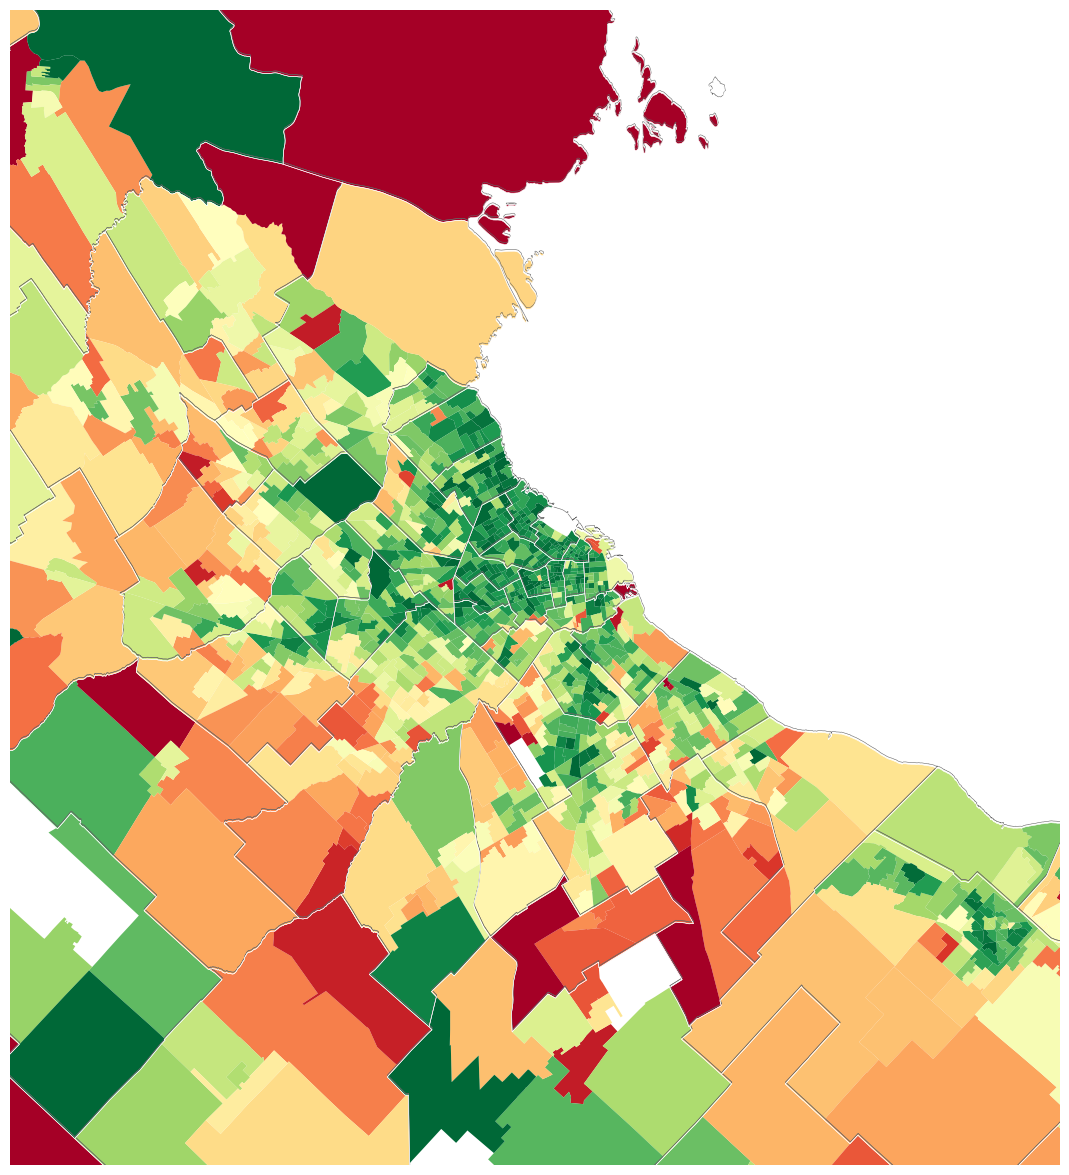

In [ ]:
fig, ax = plt.subplots(1, figsize = (15, 15))

## Bordes de Departamento (doble linea)
bordes_dptos = dptos_gdf.loc[dptos_gdf.PROV_.isin(['02', '06'])].to_crs({'init': 'epsg:3395'})
bordes_dptos.translate(yoff = 220, xoff = 30).plot(color = 'None', edgecolor = '.4', lw = .4, ax = ax, zorder = 10)
bordes_dptos.translate(yoff = 0, xoff = 0).plot(color = 'None', edgecolor = 'w', lw = .4, ax = ax, zorder = 10)

pobreza_gdf.fillna(0).to_crs({'init': 'epsg:3395'}).plot(column = 'Pobreza', ax = ax, vmin = 0, vmax = .6, cmap = 'RdYlGn_r', lw = 0)

# plot bounds
custom_bounds = fracs_GBA_gdf.to_crs({'init': 'epsg:3395'}).total_bounds
x0, y0, x1, y1 = box(*custom_bounds).buffer(-15000).bounds 
# minx, miny, maxx, maxy

ax.set_xlim(x0, x1); ax.set_ylim(y0, y1)
ax.axis('off')

# ejido90 = gpd.read_file('./../../ejidos_ARG/geo/ejido90')
# ejido90.to_crs({'init': 'epsg:3395'}).plot(color = 'w', ax = ax)

# ejido60 = gpd.read_file('./../../ejidos_ARG/geo/ejido60')
# ejido60.to_crs({'init': 'epsg:3395'}).plot(color = 'w', alpha = .6, ax = ax)

plt.savefig("./mapa_portada.png")
plt.show()